# INF-0616 - Aula 3: construindo uma rede do zero

Escrito por **Rising Odegua** ([link to his GitHub](https://heartbeat.fritz.ai/building-a-neural-network-from-scratch-using-python-part-1-6d399df8d432)), com pequenas modificações de **Esther Colombini**.

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina:
[moodle.lab.ic.unicamp.br/680](https://moodle.ic.unicamp.br/moodle/course/view.php?id=680)

Instituto de Computação - Unicamp 2025


    

2-layer neural network for a binary classification task

In [ ]:
class NeuralNet():
    '''
    Uma rede com duas camadas
    '''

    def __init__(self, layers=[13,8,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.layers = layers
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.X = None
        self.y = None

    def init_weights(self):
        '''
        Inicialize os pesos a partir de uma distribuição normal aleatória
        '''
        np.random.seed(1) # Seed do gerador de números aleatórios
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1])
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2])
        self.params['b2'] = np.random.randn(self.layers[2],)

    def relu(self,Z):
        '''
        A função ReLu executa uma operação limiar
        para cada elemento de entrada em que valores menores que
        zero são definidos como zero.
        '''
        return np.maximum(0, Z)


    def sigmoid(self,Z):
        '''
        A função sigmóide recebe números reais em qualquer faixa e
        adequa para uma saída com valor real entre 0 e 1.
        '''
        return 1.0 / (1.0 + np.exp(-Z))

    def entropy_loss(self,y, yhat):
        nsample = len(y)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((1 - y), np.log(1 - yhat))))
        return loss


    def forward_propagation(self):
        '''
        Executa o forward pass
        '''

        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss


    def back_propagation(self,yhat):
        '''
        Computa as derivadas e atualiza os pesos e bias de acordo
        '''
        def dRelu(x):
            x[x<=0] = 0
            x[x>0] = 1
            return x

        dl_wrt_yhat = -(np.divide(self.y,yhat) - np.divide((1 - self.y),(1-yhat)))
        dl_wrt_sig = yhat * (1-yhat)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0)

        dl_wrt_z1 = dl_wrt_A1 * dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2


    def fit(self, X, y):
        '''
        Treina a rede neural usando os dados e rótulos passados
        '''
        self.X = X
        self.y = y
        self.init_weights() #initializa pesos e bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)


    def predict(self, X):
        '''
        Realiza o predict dos dados de teste
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)


    def acc(self, y, yhat):
        '''
        Calcula a acurácia entre o valor predito e o real
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plota a curva de loss
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()

Shape of train set is (242, 13)
Shape of test set is (61, 13)
Shape of train label is (242, 1)
Shape of test labels is (61, 1)


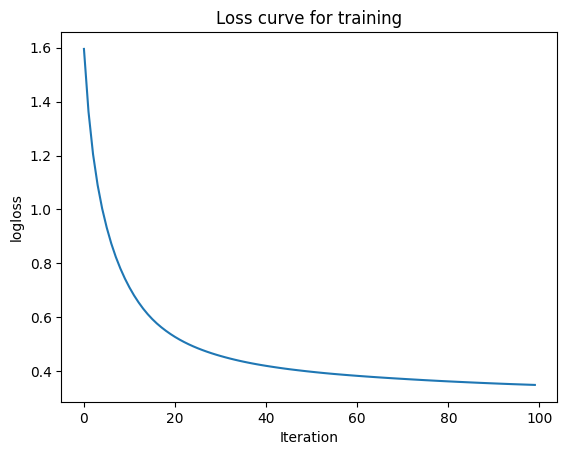

Train accuracy is 84
Test accuracy is 78


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") #sem warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('cleveland.csv', header = None)

df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang',
              'oldpeak', 'slope', 'ca', 'thal', 'target']

### 1 = male, 0 = female
df.isnull().sum()

df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df['thal'] = df.thal.fillna(df.thal.mean())
df['ca'] = df.ca.fillna(df.ca.mean())

X = df.iloc[:, :-1].values
y_label = df.iloc[:, -1].values.reshape(X.shape[0], 1)

#separa dados de treino e teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

#normalizar o dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

nn = NeuralNet() # cria o modelo da NN
nn.fit(Xtrain, ytrain) #treine o modelo

nn.plot_loss()

train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print("Train accuracy is {}".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}".format(nn.acc(ytest, test_pred)))



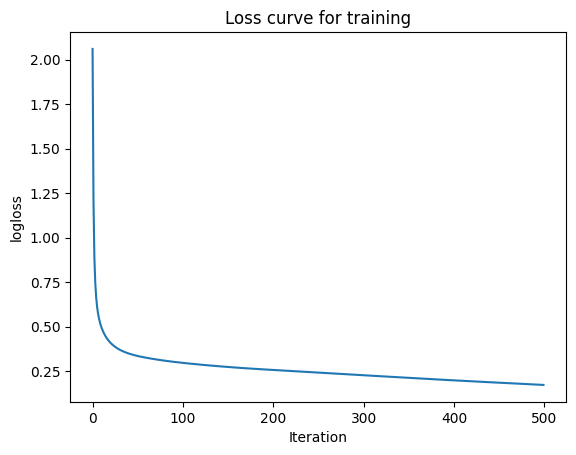

Train accuracy is 94
Test accuracy is 81


In [ ]:
nn = NeuralNet(layers=[13,20,1], learning_rate=0.001, iterations=500) # cria um novo modelo
nn.fit(Xtrain, ytrain) #treine o modelo

nn.plot_loss()

train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print("Train accuracy is {}".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}".format(nn.acc(ytest, test_pred)))
